# Part 3 - Predictive Modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

# Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY MM DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

## To-do:
- Create a retention feature. TRUE if they were active in the last 30 days before collecting the data.
- Perform Data Wrangling, Data Cleaning, and Feature Engineering.
- Create predictive model.
- Tune model.
- Evaluate best model.

# Import necessary packages

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from datetime import timedelta
import pickle
import datetime

In [2]:
data = pd.read_json('ultimate_data_challenge.json')

In [3]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
data[['signup_date','last_trip_date']].describe(datetime_is_numeric=True)

,signup_date,last_trip_date
count,50000,50000
unique,31,182
top,2014-01-18,2014-06-29
freq,2948,2036


`signup_date` spans from January 1st to January 31st, and `last_trip_date` spans from January 1st to July 1st.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


`avg_rating_by_driver` and `avg_rating_of_driver` can be imputed with the mean. `phone` is a categorical variable and we will be One-Hot encoding it for the model, so the missing values (which are less than 1% of the observations) will be taken care of.

We also need to change some features to their respective type:

### Imputing missing values:

In [6]:
data.avg_rating_of_driver.fillna(data.avg_rating_of_driver.mean(), inplace = True)
data.avg_rating_by_driver.fillna(data.avg_rating_by_driver.mean(), inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### Changing data types:

In [11]:
data[['signup_date','last_trip_date']]=pd.to_datetime(data[['signup_date','last_trip_date']].stack(), format= '%Y-%m-%d').unstack()
#data.phone = data.phone.astype('category')
#data.active = data.active.astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### Creating target variable:

In [12]:
date_list = [data.last_trip_date.max() - timedelta(days=x) for x in range(0,31)]
data['active'] = data.apply(lambda x: 1 if x.last_trip_date in date_list else 0, axis=1)

In [45]:
data.ultimate_black_user = data.ultimate_black_user.apply(lambda x: 1 if x else 0)

In [46]:
data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0


In [14]:
data.active.value_counts()

0    31196
1    18804
Name: active, dtype: int64

37.6% of users remained active

# Exploratory Data Analysis

In [47]:
data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,0.37708,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.564977,0.222336,19.958811,0.48466,37.081503,5.707357,0.445753,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000


There are some outliers in `trips_in_first_30_days`, `avg_surge`, `surge_pct`, and `avg_dist`. However, I think it will be a good idea to keep them.

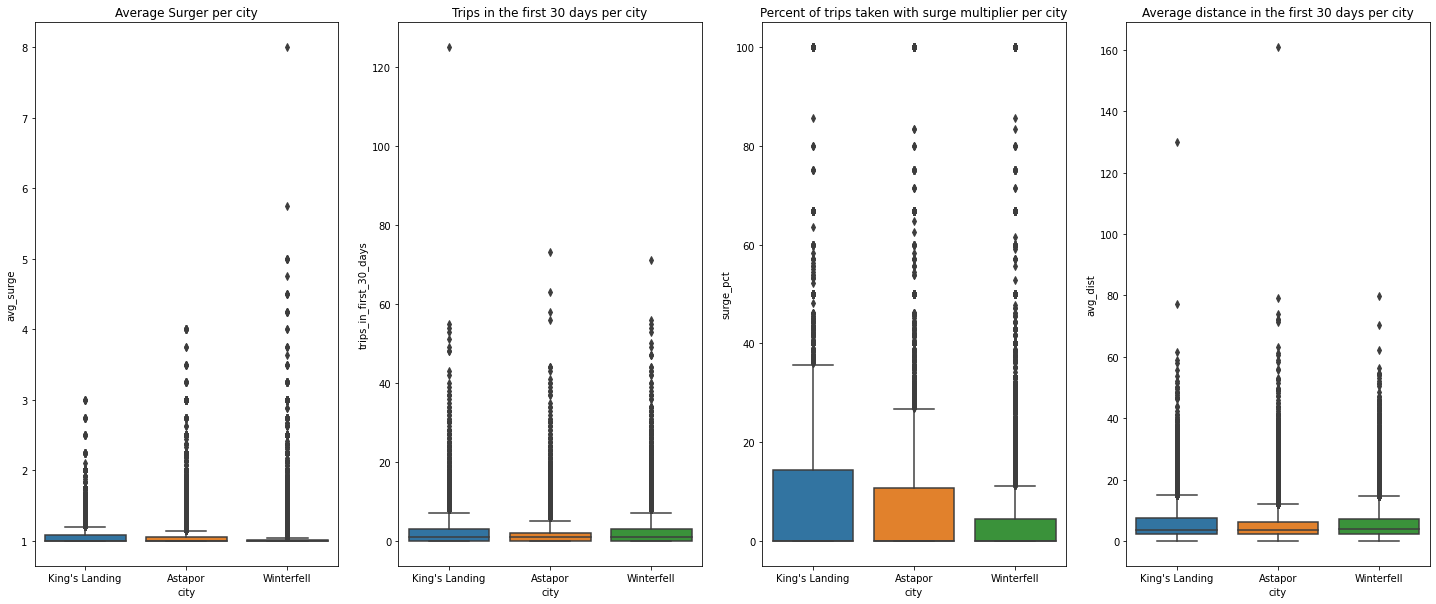

In [56]:
plt.figure(figsize=(25,10))
plt.subplot(1, 4, 1)
sns.boxplot(data = data, y='avg_surge', x='city')
plt.title('Average Surger per city')


plt.subplot(1, 4, 2)
sns.boxplot(data = data, y='trips_in_first_30_days', x='city')
plt.title('Trips in the first 30 days per city')


plt.subplot(1, 4, 3)
sns.boxplot(data = data, y='surge_pct', x='city')
plt.title('Percent of trips taken with surge multiplier per city')


plt.subplot(1, 4, 4)
sns.boxplot(data = data, y='avg_dist', x='city')
plt.title('Average distance in the first 30 days per city')
plt.show()


Let us look at the number of signups per city:

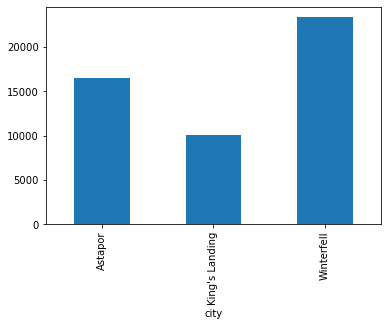

In [15]:
data.groupby('city').signup_date.count().plot(kind='bar')
plt.show()

Let us look at the average rating of drivers per city:

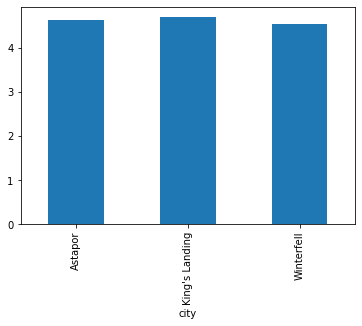

In [16]:
data.groupby('city').avg_rating_of_driver.mean().plot(kind='bar')
plt.show()

In [17]:
data.groupby('city').avg_rating_of_driver.mean()

city
Astapor           4.625523
King's Landing    4.693643
Winterfell        4.544608
Name: avg_rating_of_driver, dtype: float64

The difference per city is very minimal. Let's see if it's the same for the average rating by driver:

In [57]:
data.groupby('city').avg_rating_by_driver.mean()

city
Astapor           4.798780
King's Landing    4.852865
Winterfell        4.731117
Name: avg_rating_by_driver, dtype: float64

It is very minimal as well.

Let's see at the number of active users per city:

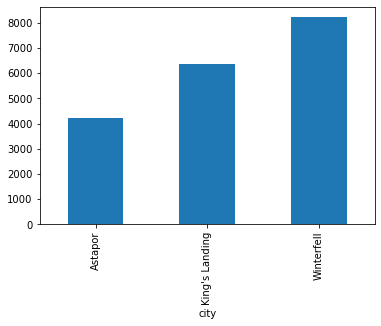

In [18]:
data.groupby('city').active.sum().plot(kind='bar')
plt.show()

Here we can see that Winterfell is the most active city in all the categories. It retains the most users, but it also had the most signups, retaining 35.2%. However, King's Landing, even though it got the least signups, retaining 62.81% of its users. And then we have Astapor, that retained 25.58% of its users.

Now let's look at out distributions:

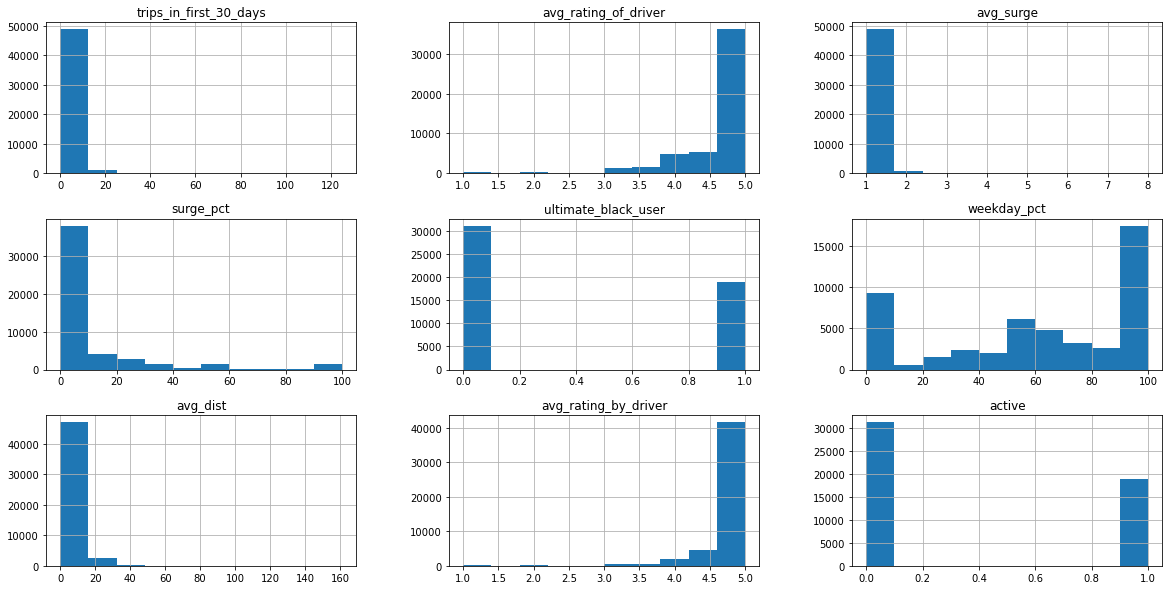

In [66]:
data.hist(figsize=(20,10))
plt.show()

As expected, our outliers are causing our distributions to be highly skewed. This should not affect out RandomForestClassifier, but if it does, we'll come back to deal with them.

In [82]:
df = pd.get_dummies(data)

In [87]:
df

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.700000,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,2014-01-29,5.000000,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,2014-01-06,4.300000,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,2014-01-10,4.600000,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,2014-01-27,4.400000,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2014-01-25,5.000000,1.00,2014-06-05,0.0,0,100.0,5.63,4.2,1,0,1,0,0,1
49996,1,2014-01-24,4.601559,1.00,2014-01-25,0.0,0,0.0,0.00,4.0,0,1,0,0,0,1
49997,0,2014-01-31,5.000000,1.00,2014-05-22,0.0,1,100.0,3.86,5.0,0,0,0,1,1,0
49998,2,2014-01-14,3.000000,1.00,2014-01-15,0.0,0,100.0,4.58,3.5,0,1,0,0,0,1


# Predictive Modeling

## RandomForestClassifier

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV

In [140]:
X = df.drop(columns=['active','signup_date','last_trip_date'])
y= df.active
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [92]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

'              precision    recall  f1-score   support\n\n           0       0.80      0.81      0.80      7800\n           1       0.67      0.66      0.66      4700\n\n    accuracy                           0.75     12500\n   macro avg       0.73      0.73      0.73     12500\nweighted avg       0.75      0.75      0.75     12500\n'

In [93]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.81      0.80      7800
           1       0.67      0.66      0.66      4700

    accuracy                           0.75     12500
   macro avg       0.73      0.73      0.73     12500
weighted avg       0.75      0.75      0.75     12500



In [103]:
rf_grid = RandomForestClassifier(random_state=42)
grid_params = {
        'min_samples_leaf': [5,50,100],
        'max_depth' : [10,100, None],
        'n_estimators': [100,1000]
        }
rf_grid_cv = GridSearchCV(rf_grid, param_grid=grid_params, cv=3, n_jobs=-1)

In [104]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 100, None],
                         'min_samples_leaf': [5, 50, 100],
                         'n_estimators': [100, 1000]})

In [105]:
print(rf_grid_cv.best_params_)
print(rf_grid_cv.best_estimator_)

{'max_depth': 100, 'min_samples_leaf': 5, 'n_estimators': 1000}
RandomForestClassifier(max_depth=100, min_samples_leaf=5, n_estimators=1000,
                       random_state=42)


In [106]:
print(classification_report(y_test, rf_grid_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      7800
           1       0.74      0.66      0.69      4700

    accuracy                           0.78     12500
   macro avg       0.77      0.76      0.76     12500
weighted avg       0.78      0.78      0.78     12500



## XGBoost

In [107]:
import xgboost as xgb
xg_cl = xgb.XGBClassifier(objective='reg:logistic', n_estimators=100, seed=123)

In [108]:
xg_cl.fit(X_train, y_train)
xgb_pred = xg_cl.predict(X_test)

In [110]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      7800
           1       0.73      0.67      0.70      4700

    accuracy                           0.78     12500
   macro avg       0.77      0.76      0.77     12500
weighted avg       0.78      0.78      0.78     12500



In [113]:
xg_clf = xgb.XGBClassifier(objective='reg:logistic', seed=123)
params= {'n_estimators': [100,1000],
    'learning_rate': [0.01,0.1,0.5,0.9],
    'max_depth': [100,None]}
xg_random_cv =  RandomizedSearchCV(xg_clf, params, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
xg_random_cv.fit(X_train,y_train)

D:\Desktop\Springboard_Data_Science\Enviroments\pandas-profiling\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 16 is smaller than n_iter=100. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:  1.8min remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.6min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(objective='reg:logistic', seed=123),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.5, 0.9],
                                        'max_depth': [100, None],
                                        'n_estimators': [100, 1000]},
                   random_state=42, verbose=2)

In [117]:
print(xg_random_cv.best_params_)
print(xg_random_cv.best_estimator_)

{'n_estimators': 1000, 'max_depth': 100, 'learning_rate': 0.01}
XGBClassifier(learning_rate=0.01, max_depth=100, n_estimators=1000,
              objective='reg:logistic', seed=123)


In [115]:
xgb_pred = xg_random_cv.predict(X_test)
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      7800
           1       0.69      0.65      0.67      4700

    accuracy                           0.76     12500
   macro avg       0.74      0.74      0.74     12500
weighted avg       0.76      0.76      0.76     12500



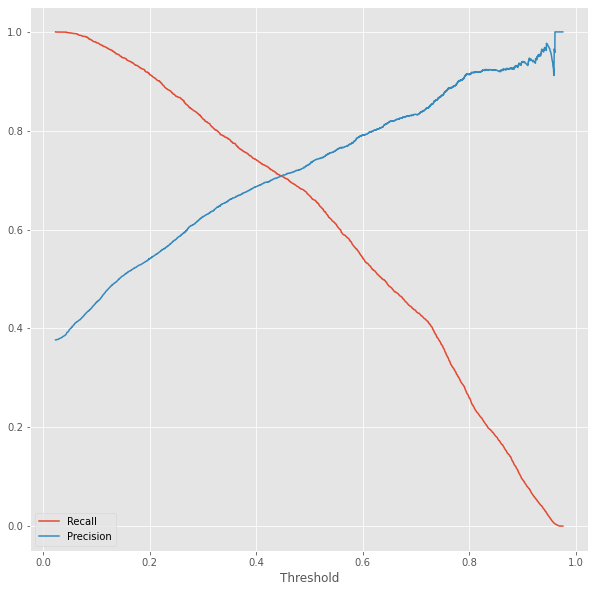

In [144]:
precision, recall, threshold = precision_recall_curve(y_test, xg_cl.predict_proba(X_test)[:,1])
plt.figure(figsize = (10,10))
plt.plot(threshold,recall[:-1],label='Recall')
plt.plot(threshold,precision[:-1],label="Precision")
plt.legend()
plt.xlabel('Threshold')
plt.show()

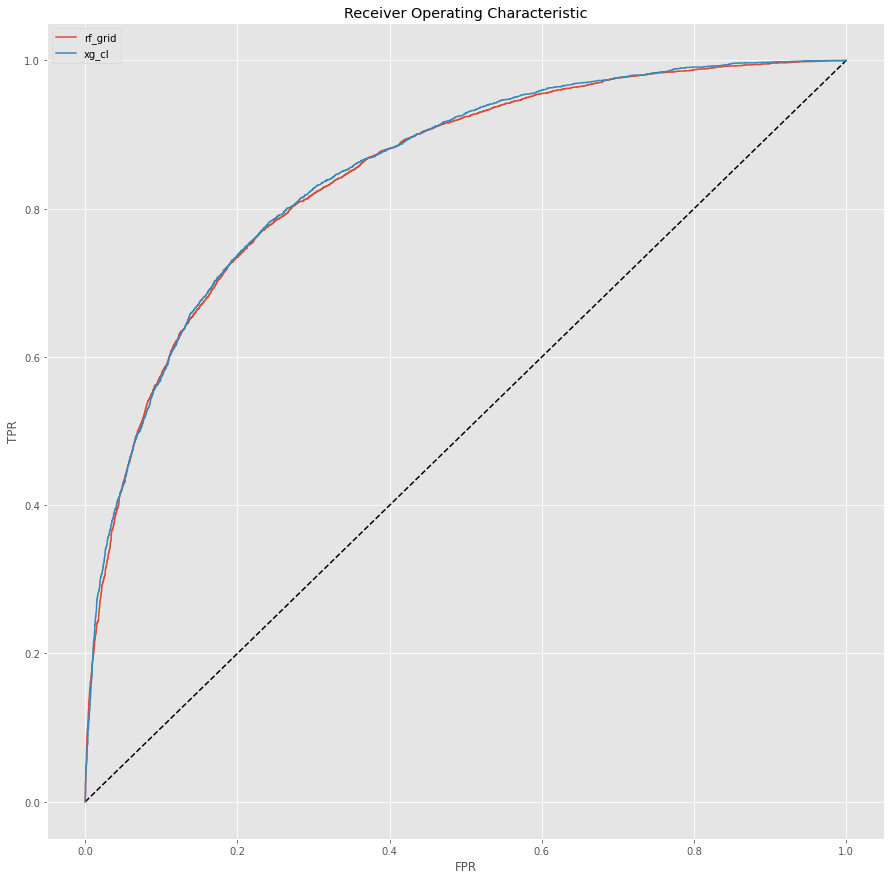

In [142]:
fpr_rfgrid , tpr_rfgrid, thresholds_rfgrid = roc_curve(y_test, rf_grid_cv.predict_proba(X_test)[:,1])
fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, xg_cl.predict_proba(X_test)[:,1])

plt.figure(figsize = (15,15))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr_rfgrid , tpr_rfgrid, label = 'rf_grid')
plt.plot(fpr_xg , tpr_xg, label= "xg_cl")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

In [143]:
print('RandomForest AUC: ', auc(fpr_rfgrid , tpr_rfgrid))
print('XGBoost AUC: ', auc(fpr_xg, tpr_xg))


RandomForest AUC:  0.848057296781233
XGBoost AUC:  0.8508164484451719


In [159]:
xg_cl.fit(X,y)
print(classification_report(y, xg_cl.predict(X)))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84     31196
           1       0.74      0.67      0.70     18804

    accuracy                           0.79     50000
   macro avg       0.78      0.76      0.77     50000
weighted avg       0.79      0.79      0.79     50000



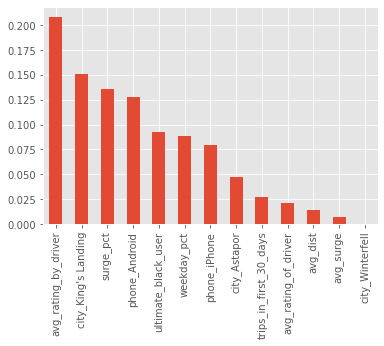

In [146]:
pd.Series(xg_cl.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot(kind='bar');

In [169]:
best_model = xg_cl
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn. __version__
best_model.X_columns = [col for col in X_train.columns]
modelpath = 'Ultimate_model.pkl'
pickle.dump(best_model, open(modelpath, 'wb'))

# Conclusions

- 37.6% of users were retained.
- King's Landing retains the most users. It would be interesting to look at the population of this city and compare it to the other two. Maybe this city has a more things to do at night and people use the service more. Or maybe the other cities have better public transport. Maybe there's just not as much competetion for the same service in King's Landing since it has the least amount of signups.
- I chose to try RandomForestClassifier and XGBoost because of the number of outliers the data had. I felt these outliers were not mistakes, but rather users and used the service way more than the mean.
- We applied hyperparameter tuning to both and the better model ended up being the XGBoost with an accuracy of 0.78 and AUC of 0.851.
- We also looked at the PR and ROC curves.
- My main concern are potential confounding variables that are not in the dataset. Such as age of user, or wheather they are a student or not. These features might explain the behavior of other variables. Maybe King's Landing is a college city? 

### Insights from model
- Average rating by driver seems to be an important feature, which may be an indicator of how pleased the rider is. So encouraging drivers to give a better experience will payoff with more users retained.
 